# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


## Подготовка данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statistics import mode

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV


import time
pd.options.mode.chained_assignment = None

Загрузим и посмотрим данные

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Наименование признаков согласно документации:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

In [4]:
#pd.plotting.scatter_matrix(df, figsize=(20,20));

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Вывод:**

- Признак `RegistrationYear` содержит аномальные значения (минимальный год выпуска 1000 год, а максимальный 9999 год).
- Признак `Power` имеет неадекватные и аномальные значения (минимальное значение 0 а максимальное 20000).
- В признаке `NumberOfPictures` нет данных.
- В целевом признаке `Price` есть аномальное значение 0.
- Так же в признаке `RegistrationMonth` есть 0 значение (скорее всего часть данных потеряна).
- В `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` много пропущенных значений.

### Названия столбцов

Приведем наименования столбцов к "змеиному" регистру через функцию snake_case

In [6]:
def snake_case(str):
    return ''.join(['_' + i.lower() if i.isupper()
               else i for i in str]).lstrip('_')

df.columns = [snake_case(i) for i in df.columns]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Ненужные значения

Удалим лишнюю информацию. `number_of_pictures` не содержит данных. `date_crawled`, `date_created`, `last_seen` и `postal_code` также содержат информацию, которую в данном исследовании не будем использовать.

In [7]:
df = df.drop(['postal_code', 'last_seen', 'number_of_pictures', 'date_created'], axis=1)
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


### Аномальные значения

Напишем функцию для построения графиков распределения. И посмотрим распределения значений параметров

In [8]:
def diagrams(data_series):
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'График распределения {data_series.name}')
    axs[0].set(title='Гистограмма')
    axs[0].grid()
    axs[0].hist(data_series, bins=50);
    axs[1].set(title='Диаграмма размаха')
    axs[1].grid()
    axs[1].boxplot(data_series);

#### Цена

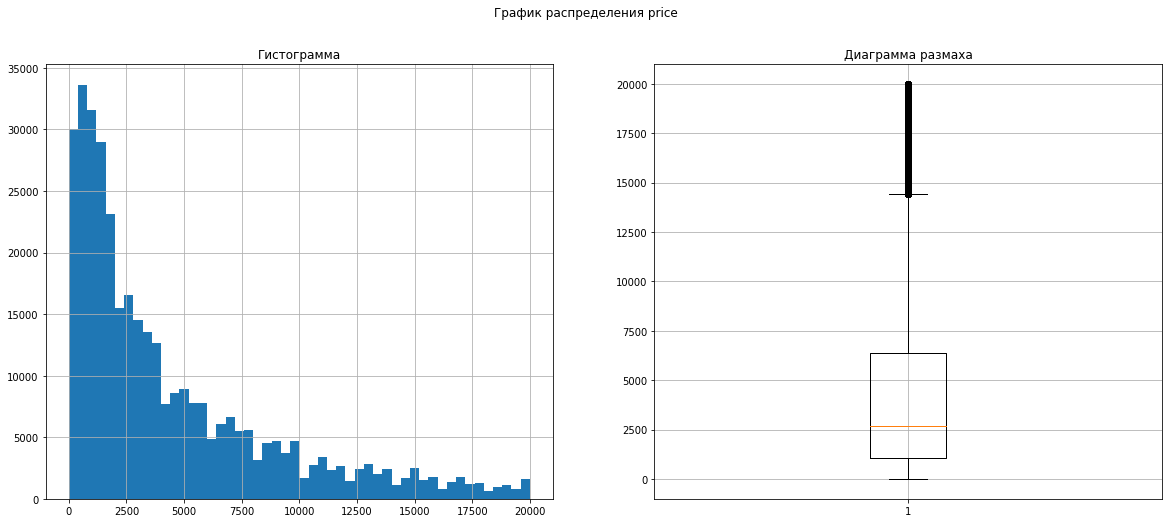

In [9]:
diagrams(df['price'])

Удалим данные с авто ценой ниже 100$.

In [10]:
df = df[df['price'] > 100]

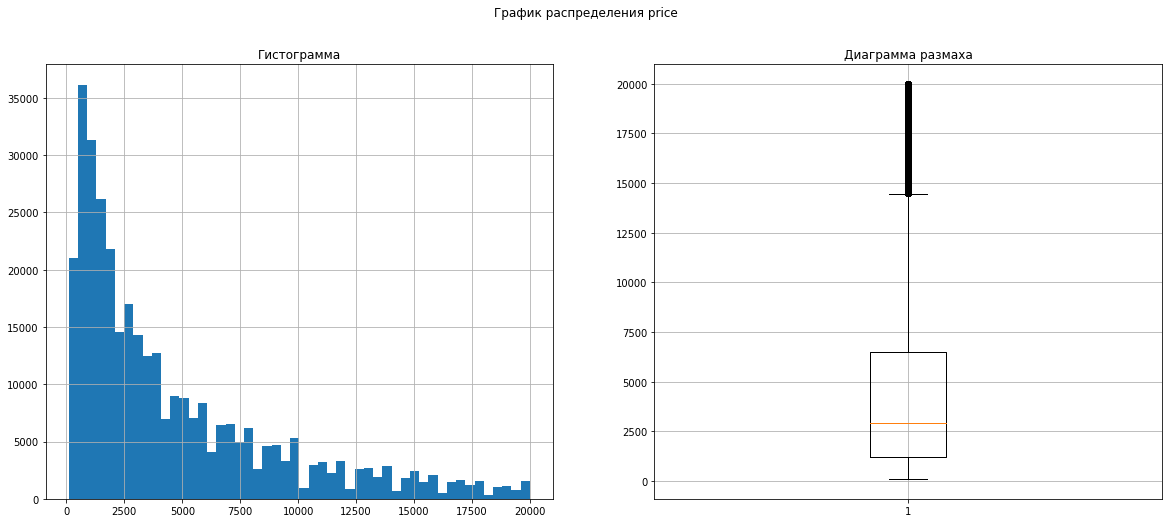

In [11]:
diagrams(df['price'])

#### Мощность

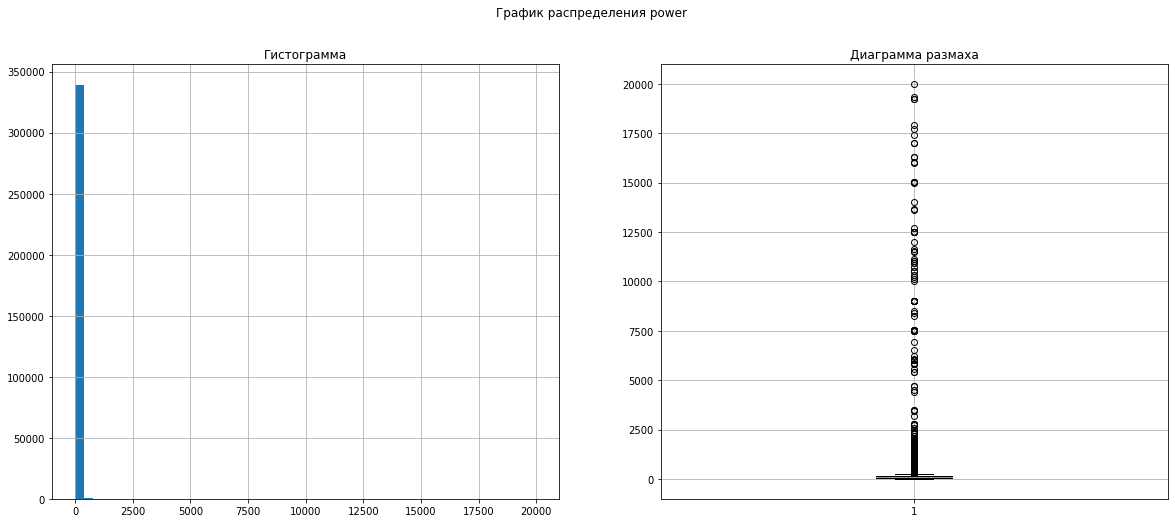

In [12]:
diagrams(df['power'])

Мощность авто также ограничим разумными пределами от 10 до 1000 л.с.

In [13]:
df = df[(df['power'] >= 10) & (df['power'] <= 1000)]

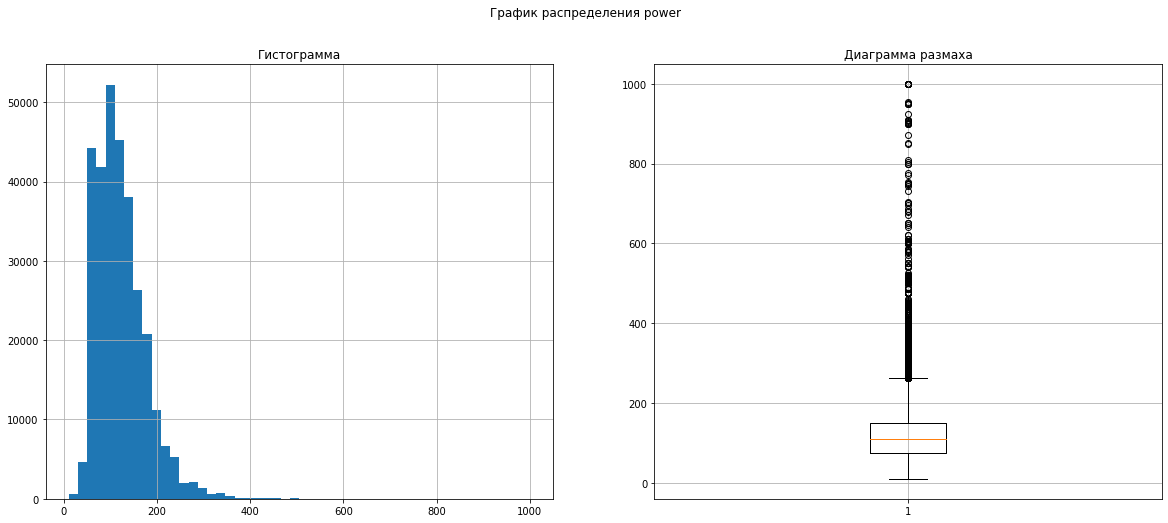

In [14]:
diagrams(df['power'])

#### Год регистрации

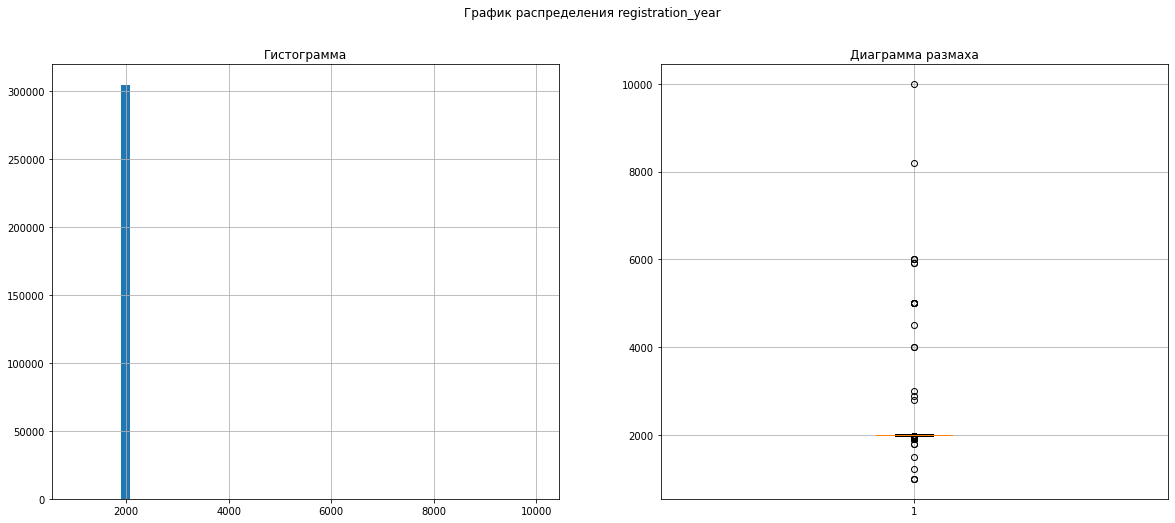

In [15]:
diagrams(df['registration_year'])

Год регистрации автомобиля ограничим разумными датами с 1960 г.в.

In [16]:
df = df[(df['registration_year'] > 1960) & (df['registration_year'] < 2023)]

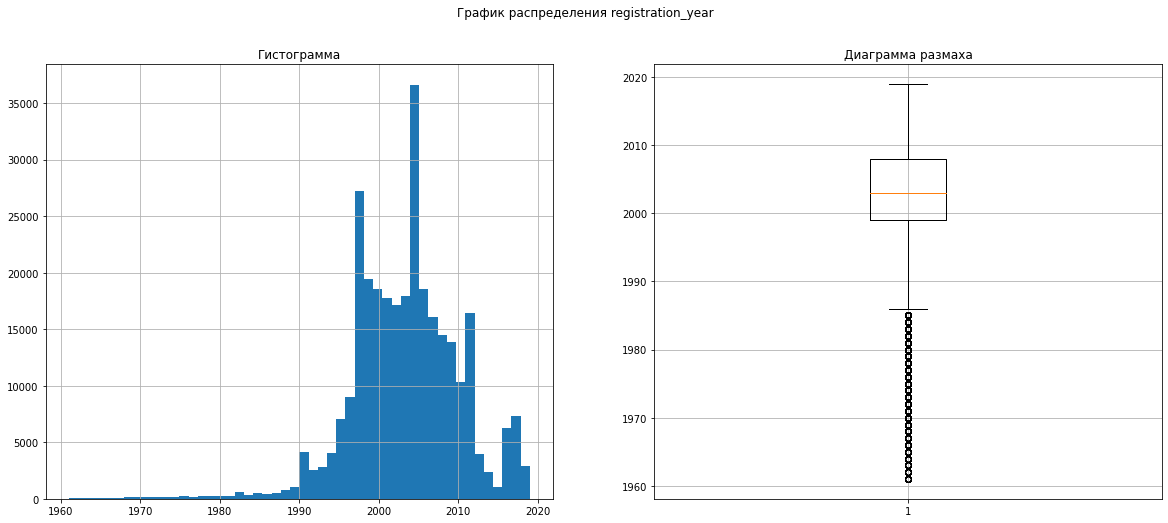

In [17]:
diagrams(df['registration_year'])

Посмотрим на дату выгрузки объявлений и сравним с годом регистрации

In [18]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%dT%H:%M:%S')
#df['registration_year'] = pd.to_datetime(df['registration_year'], format='%Y')

In [19]:
df[(df['registration_year'] > pd.DatetimeIndex(df['date_crawled']).year)]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no
...,...,...,...,...,...,...,...,...,...,...,...,...
354099,2016-03-17 15:45:46,4900,NaN,2017,manual,69,polo,150000,12,gasoline,volkswagen,NaN
354112,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN
354140,2016-03-29 16:47:29,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN
354203,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no


Авто в базе уже есть, но год регистрации еще не наступил. Думаю удалить эти данные.

In [20]:
df = df[df['registration_year'] < pd.DatetimeIndex(df['date_crawled']).year]

In [21]:
df = df.drop('date_crawled', axis=1)

### Пропуски

Посмотрим на процент количества пропусков

In [22]:
def passage(df):
    count=round(df.isna().sum(), 2)
    percent=round((df.isna().sum() / df.shape[0]) * 100, 2)
    data=pd.concat([count, percent], axis=1)
    data.columns = ['Количество пропусков', 'Пропуски %']
    display(data[data['Количество пропусков'] != 0].sort_values(by = 'Пропуски %', ascending = False))

passage(df)

,Количество пропусков,Пропуски %
repaired,39592,13.74
fuel_type,12634,4.38
model,10021,3.48
gearbox,4730,1.64
vehicle_type,4575,1.59


#### Пропуски (модель)

Отфильтруем в начале пропуски в признаках, которые в основном влияют на ценообразование автомобиля. Удалим данные, имеющие пропуски в названии модели.

In [23]:
df = df[~df.model.isna()]

Также удалим данные где модель неизвестна, а тип кузова не заполнен. Эти данные считаем мусорными.

In [24]:
df[(df.vehicle_type.isna()) & (df.model == 'other')].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
2320,800,NaN,2005,manual,101,other,150000,12,NaN,mazda,NaN
3238,1300,NaN,1995,manual,163,other,150000,5,petrol,ford,NaN
3902,900,NaN,1985,manual,41,other,80000,0,NaN,suzuki,yes
7978,2900,NaN,2005,manual,74,other,125000,3,NaN,citroen,NaN
8247,500,NaN,1995,manual,133,other,150000,0,petrol,honda,NaN


In [25]:
df = df[~((df.vehicle_type.isna()) & (df.model == 'other'))]

#### Пропуски (тип кузова)

Для восстановления пропусков в наименовании кузова сгруппируем наши данные, для того чтобы по модели авто видно было наиболее встречающееся наименование кузова (моду).

In [26]:
df.groupby('model')['vehicle_type'].value_counts(dropna=False).head(15)

model  vehicle_type
100    sedan           249
       wagon           100
       NaN               7
       coupe             2
       convertible       1
145    small            18
       sedan            12
       NaN               1
       coupe             1
       other             1
147    sedan           345
       small            86
       coupe            26
       NaN              14
       other             6
Name: vehicle_type, dtype: int64

Не каждый знает тип кузова своей машины, это видно по разнообразию наименований кузова в объявлении. Примем допущение, что наиболее популярный кузов при группировке по моделям - это и есть искомое значение кузова для пропусков. Заменим пропуски применяя функцию mode.

In [27]:
df['vehicle_type'] = df['vehicle_type'].fillna(df.groupby('model')['vehicle_type'].transform(mode))

Проверим результат

In [28]:
df.groupby('model')['vehicle_type'].value_counts().head(15)

model  vehicle_type
100    sedan           256
       wagon           100
       coupe             2
       convertible       1
145    small            19
       sedan            12
       coupe             1
       other             1
147    sedan           359
       small            86
       coupe            26
       other             6
       wagon             2
156    wagon           280
       sedan           240
Name: vehicle_type, dtype: int64

#### Пропуски (тип коробки передач, тип топлива)

Аналогично, как и с пропусками по типу кузова, заменим пропуски типа КПП и типа топлива применяя группировку по модели и мощности двигателя.

In [29]:
df['gearbox'] = df['gearbox'].fillna(df.groupby(['model', 'power'])['gearbox'].transform(mode))

df['fuel_type'] = df['fuel_type'].fillna(df.groupby(['model', 'power'])['fuel_type'].transform(mode))

#### Пропуски (наличие ДТП)

Пропуски в `repaired` заменим значением unknown. 

In [30]:
df['repaired'] = df['repaired'].fillna('unknown')

#### Пропуски (итог)

Проверим итог обработки пропусков

In [31]:
passage(df)

,Количество пропусков,Пропуски %
fuel_type,398,0.14
gearbox,125,0.04


Оставшиеся пропусков немного, удалим

In [32]:
df = df.dropna()

### Дубликаты

Дубликаты нам не нужны, удалим

In [33]:
print('Явных дубликатов в данных:', df.duplicated().sum())

Явных дубликатов в данных: 23471


In [34]:
df.drop_duplicates(inplace=True)
print('Явных дубликатов в данных:', df.duplicated().sum())

Явных дубликатов в данных: 0


### Корреляция

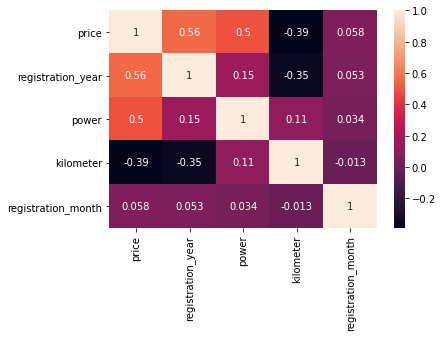

In [35]:
sns.heatmap(df.corr(), annot=True);

Сильной зависимости между признаками нет

### Вывод

- Удалены лишние признаки в данных (`date_crawled`, `date_created`, `last_seen`, `postal_code`, `number_of_pictures`).
- По возможности в данных восстановленны пропуски.

- В  registrationyear, power, price и убрали выбросы из них
- Заполнили пропуски в колонке notrepaired а остальные просто удалили




- Признак `RegistrationYear` содержит аномальные значения (минимальный год выпуска 1000 год, а максимальный 9999 год).
- Признак `Power` имеет неадекватные и аномальные значения (минимальное значение 0 а максимальное 20000).
- В признаке `NumberOfPictures` нет данных.
- В целевом признаке `Price` есть аномальное значение 0.
- Так же в признаке `RegistrationMonth` есть 0 значение (скорее всего часть данных потеряна).
- В `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` много пропущенных значений.


Удалим лишнюю информацию. `number_of_pictures` не содержит данных. `date_crawled`, `date_created`, `last_seen` и `postal_code` также содержат информацию, которую в данном исследовании не будем использовать.


Мощность авто также ограничим разумными пределами от 10 до 1000 л.с.

## Обучение моделей

### Разделение данных

Разделим данные на обучающую, валидационную и тестовую выборки

In [36]:
x = df.drop('price', axis=1)
y = df['price']

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

print(f'Размер обучающей выборки {x_train.shape} {y_train.shape}, \
     \nтестовой {x_test.shape} {y_test.shape}')

Размер обучающей выборки (190466, 10) (190466,),      
тестовой (63489, 10) (63489,)


In [38]:
del x, y, df

### Функция для обучения моделей

Создадим таблицу куда будем вносить результаты

In [39]:
list_of_results = pd.DataFrame(index=['Время обучения', 'Время предсказания', 'RMSE'])

Напишем функцию для обучения моделей.

In [40]:
%%time

list = []

def learning_model(model, X, Y, grid=None):
        
    global list_of_results
    list = []
    name_model = type(model).__name__
        
    model = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
    
    timer = time.time()
    model.fit(X, Y)
    print('GridSearchCV подбирал параметры %.2f секунд' %(time.time() - timer))
       
        
    # model.best_estimator_.fit(X, Y) Изм1: Лишний fit убрал, записал результаты обучения в results
    
    results = pd.DataFrame(model.cv_results_)
    print('Время обучения модели %.2f секунд' %results.query('mean_test_score.idxmax()')['mean_fit_time'])
    list.append(results.query('mean_test_score.idxmax()')['mean_fit_time'])
    
    # pred = model.best_estimator_.predict(X)
    # Добавим в список время предсказания
    list.append(results.query('mean_test_score.idxmax()')['mean_score_time'])
    print('Модель предсказывает за %.2f секунд' %results.query('mean_test_score.idxmax()')['mean_score_time'])
    
    # Добавим в список RMSE, умножаем на -1 т.к. GridSearch выдает отрицательное значение
    list.append(-1 * model.best_score_)
    
    print(-1 * model.best_score_)
    print(model.best_params_)
        
    list_of_results[name_model] = list
    
    return model.best_estimator_

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


### Кодирование количественных признаков

В начале закодируем `количественные` признаки.

In [41]:
col = ['registration_year', 'power', 'kilometer']

scaler = StandardScaler().fit(x_train[col])
x_train.loc[:, col] = pd.DataFrame(scaler.transform(x_train.loc[:, col]), columns=col, index=x_train.index)
x_test.loc[:, col] = pd.DataFrame(scaler.transform(x_test.loc[:, col]), columns=col, index=x_test.index)

In [42]:
x_train

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
319343,wagon,-0.601052,manual,-0.114380,focus,0.597007,12,petrol,ford,yes
181527,small,0.384075,manual,-0.854158,a2,0.597007,2,petrol,audi,no
245791,wagon,0.876639,auto,1.272702,e_klasse,0.597007,0,gasoline,mercedes_benz,unknown
29451,sedan,-0.436865,manual,-0.095886,vectra,0.597007,6,petrol,opel,no
7767,coupe,-0.272677,manual,0.070564,astra,0.597007,8,petrol,opel,no
...,...,...,...,...,...,...,...,...,...,...
317322,bus,0.876639,manual,-0.299325,meriva,0.597007,5,petrol,opel,unknown
6764,small,1.861767,auto,-1.168563,other,-2.677485,4,electric,renault,no
287249,small,0.219887,manual,-1.131574,corsa,-1.040239,10,petrol,opel,yes
318052,small,1.040827,manual,-0.724697,fiesta,0.597007,5,petrol,ford,yes


In [43]:
x_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
319343,wagon,-0.601052,manual,-0.114380,focus,0.597007,12,petrol,ford,yes
181527,small,0.384075,manual,-0.854158,a2,0.597007,2,petrol,audi,no
245791,wagon,0.876639,auto,1.272702,e_klasse,0.597007,0,gasoline,mercedes_benz,unknown
29451,sedan,-0.436865,manual,-0.095886,vectra,0.597007,6,petrol,opel,no
7767,coupe,-0.272677,manual,0.070564,astra,0.597007,8,petrol,opel,no


In [44]:
# Переменная понадобится для проверки catboost в конце на тестовых данных
x_test_cat = x_test.copy()
x_train_cat = x_train.copy()

### CatBoost

Так как CatBoost не требует кодирования `категориальных` признаков, ими займемся позже.

In [45]:
%%time

cat_features = ['gearbox', 'model', 'brand', 'vehicle_type', 'fuel_type', 'repaired']

cat_model = CatBoostRegressor(cat_features=cat_features,
                              loss_function='RMSE',
                              verbose=False,
                              random_state=1
                             )

# Создадим словарь параметров
grid = {'learning_rate': [0.1],
        'depth': [5, 7],
        #'l2_leaf_reg': [1, 5, 9],
        'iterations' : [100, 200]
       }

#Обучим модель и подберем наилучшие параметры в нашем диапазоне
cat_model = learning_model(cat_model, x_train_cat, y_train, grid)

GridSearchCV подбирал параметры 234.44 секунд
Время обучения модели 30.19 секунд
Модель предсказывает за 0.16 секунд
1598.5519720660614
{'depth': 7, 'iterations': 200, 'learning_rate': 0.1}
CPU times: user 3min 44s, sys: 1.91 s, total: 3min 46s
Wall time: 3min 54s


In [46]:
list_of_results

,CatBoostRegressor
Время обучения,30.190994
Время предсказания,0.158550
RMSE,1598.551972


### Кодирование категориальных признаков

Посмотрим количество уникальных значений по признакам

In [47]:
x_train.nunique()

vehicle_type            8
registration_year      55
gearbox                 2
power                 427
model                 247
kilometer              13
registration_month     13
fuel_type               7
brand                  39
repaired                3
dtype: int64

Некоторые `категориальные` признаки имеют слишком большое количество уникальных значений. Применим порядковое кодирование ~LabelEncoder~ OrdinalEncoder.

In [48]:
# Было
x_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
319343,wagon,-0.601052,manual,-0.114380,focus,0.597007,12,petrol,ford,yes
181527,small,0.384075,manual,-0.854158,a2,0.597007,2,petrol,audi,no
245791,wagon,0.876639,auto,1.272702,e_klasse,0.597007,0,gasoline,mercedes_benz,unknown
29451,sedan,-0.436865,manual,-0.095886,vectra,0.597007,6,petrol,opel,no
7767,coupe,-0.272677,manual,0.070564,astra,0.597007,8,petrol,opel,no


In [49]:
#col = ['gearbox', 'model', 'brand']
#x_train.loc[:, col] = x_train.loc[:, col].apply(LabelEncoder().fit_transform)
#x_test.loc[:, col] = x_test.loc[:, col].apply(LabelEncoder().fit_transform)

In [50]:
col = ['gearbox', 'model', 'brand']

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(x_train[col])

x_train[col] = encoder.transform(x_train[col])
x_test[col] = encoder.transform(x_test[col])

In [51]:
x_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
319343,wagon,-0.601052,1.0,-0.114380,103.0,0.597007,12,petrol,10.0,yes
181527,small,0.384075,1.0,-0.854158,27.0,0.597007,2,petrol,1.0,no
245791,wagon,0.876639,0.0,1.272702,95.0,0.597007,0,gasoline,20.0,unknown
29451,sedan,-0.436865,1.0,-0.095886,231.0,0.597007,6,petrol,24.0,no
7767,coupe,-0.272677,1.0,0.070564,42.0,0.597007,8,petrol,24.0,no


Там где уникальных значений не так много, применим горячее кодирование OHE.

In [52]:
#col = ['vehicle_type', 'fuel_type', 'repaired']
#x_train = (x_train
#         .join(pd.get_dummies(x_train[col], drop_first=True))
#         .drop(col, axis=1)
#          )
#x_test = (x_test
#         .join(pd.get_dummies(x_test[col], drop_first=True))
#         .drop(col, axis=1)
#          )

In [53]:
col = ['vehicle_type', 'fuel_type', 'repaired']

encoder = OneHotEncoder()
encoder.fit(x_train[col])

temp_df = pd.DataFrame(encoder.transform(x_train[col]).toarray(), 
                       columns=encoder.get_feature_names(), 
                       index=x_train.index
                      )
x_train = x_train.join(temp_df).drop(col, axis=1)


temp_df = pd.DataFrame(encoder.transform(x_test[col]).toarray(), 
                       columns=encoder.get_feature_names(), 
                       index=x_test.index
                      )
x_test = x_test.join(temp_df).drop(col, axis=1)

del temp_df, encoder

Вот что у нас получилось

In [54]:
x_train.head()

,registration_year,gearbox,power,model,kilometer,registration_month,brand,x0_bus,x0_convertible,x0_coupe,...,x1_cng,x1_electric,x1_gasoline,x1_hybrid,x1_lpg,x1_other,x1_petrol,x2_no,x2_unknown,x2_yes
319343,-0.601052,1.0,-0.114380,103.0,0.597007,12,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
181527,0.384075,1.0,-0.854158,27.0,0.597007,2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
245791,0.876639,0.0,1.272702,95.0,0.597007,0,20.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29451,-0.436865,1.0,-0.095886,231.0,0.597007,6,24.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7767,-0.272677,1.0,0.070564,42.0,0.597007,8,24.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


### LGBMRegressor

In [55]:
%%time

lgbm_model = LGBMRegressor(random_state=1, n_jobs=-1)

# Создадим словарь параметров
grid = {"n_estimators": [100, 200],
        "max_depth": [5, 7]
        }

#Обучим модель и подберем наилучшие параметры в нашем диапазоне
lgbm_model = learning_model(lgbm_model, x_train, y_train, grid)

GridSearchCV подбирал параметры 2082.88 секунд
Время обучения модели 85.79 секунд
Модель предсказывает за 1.00 секунд
1587.816065296528
{'max_depth': 7, 'n_estimators': 200}
CPU times: user 33min 46s, sys: 45 s, total: 34min 31s
Wall time: 34min 42s


Проверим еще раз LGBM на сырых данных (категориальные признаки не обработаны). Укажем categorical_feature=cat_features

In [56]:
%%time

x_train_cat[cat_features] = x_train_cat[cat_features].astype('category')

lgbm_model = LGBMRegressor(random_state=2, n_jobs=-1)


#Обучим модель и подберем наилучшие параметры в нашем диапазоне
lgbm_model_cat = learning_model(lgbm_model, x_train_cat, y_train, grid)

GridSearchCV подбирал параметры 1128.58 секунд
Время обучения модели 88.99 секунд
Модель предсказывает за 1.35 секунд
1541.471846680344
{'max_depth': 7, 'n_estimators': 200}
CPU times: user 18min 19s, sys: 22.5 s, total: 18min 41s
Wall time: 18min 48s


In [57]:
list_of_results

,CatBoostRegressor,LGBMRegressor
Время обучения,30.190994,88.993197
Время предсказания,0.158550,1.345039
RMSE,1598.551972,1541.471847


### RandomForestRegressor

In [58]:
%%time

forest_model = RandomForestRegressor(random_state=1, n_jobs=-1)

# Создадим словарь параметров
grid = {"n_estimators": [100, 200],
        "max_depth": [5, 7]
        }

#Обучим модель и подберем наилучшие параметры в нашем диапазоне
forest_model = learning_model(forest_model, x_train, y_train, grid)

GridSearchCV подбирал параметры 362.52 секунд
Время обучения модели 20.67 секунд
Модель предсказывает за 0.36 секунд
2061.7054622827986
{'max_depth': 7, 'n_estimators': 100}
CPU times: user 6min, sys: 1.35 s, total: 6min 1s
Wall time: 6min 2s


Посмотрим на целевые метрики при обучении моделей

## Анализ моделей

На обучающей выборке модели показали следующие результаты

In [59]:
list_of_results

,CatBoostRegressor,LGBMRegressor,RandomForestRegressor
Время обучения,30.190994,88.993197,20.673425
Время предсказания,0.158550,1.345039,0.364366
RMSE,1598.551972,1541.471847,2061.705462


CatBoostRegressor и LGBMRegressor схожи по RMSE, но CatBoostRegressor значительно превосходит по скорости обучения и предсказания. Выберем лучшей моделью (при схожих гиперпараметрах) CatBoostRegressor. Посмотрим на RMSE на тестовой выборке

In [70]:
def test_model(model, X, Y):
    
    global list_of_results
    
    pred = model.predict(X)
    rmse = mean_squared_error(Y, pred, squared=False)
    
    list_of_results.loc['RMSE_test', type(model).__name__] = rmse

In [71]:
test_model(cat_model, x_test_cat, y_test)

In [62]:
#test_model(lgbm_model, x_test, y_test)

In [63]:
#test_model(forest_model, x_test, y_test)

In [72]:
list_of_results

,CatBoostRegressor,LGBMRegressor,RandomForestRegressor
Время обучения,30.190994,88.993197,20.673425
Время предсказания,0.158550,1.345039,0.364366
RMSE,1598.551972,1541.471847,2061.705462
RMSE_test,1574.259731,NaN,NaN


Сравним модели по целевым метрикам

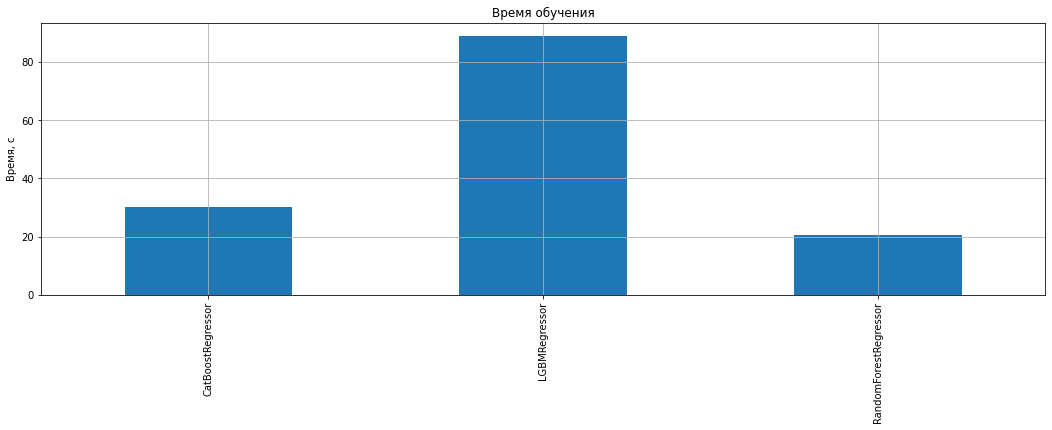

In [73]:
list_of_results.T['Время обучения'].plot(kind='bar', 
                                         grid=True, 
                                         figsize=(18, 5),
                                         ylabel='Время, с',
                                         title='Время обучения');

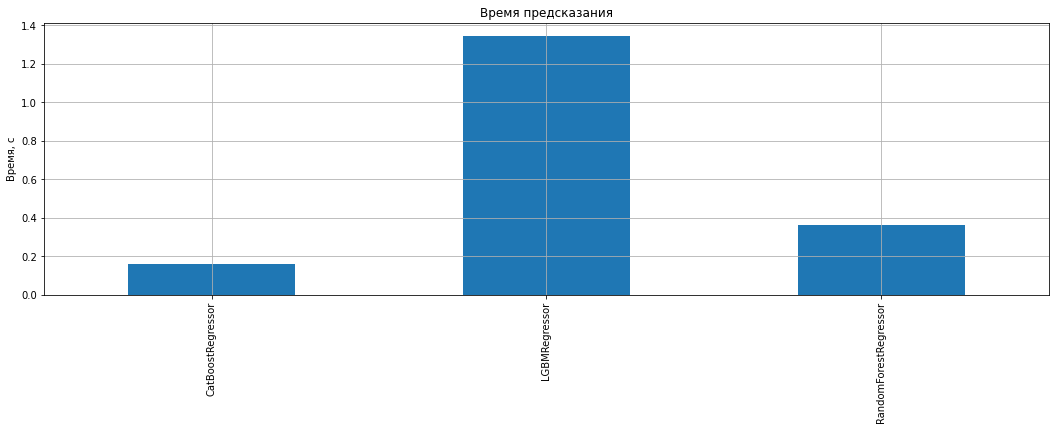

In [74]:
list_of_results.T['Время предсказания'].plot(kind='bar',
                                             grid=True,
                                             figsize=(18, 5),
                                             ylabel='Время, с',
                                             title='Время предсказания');

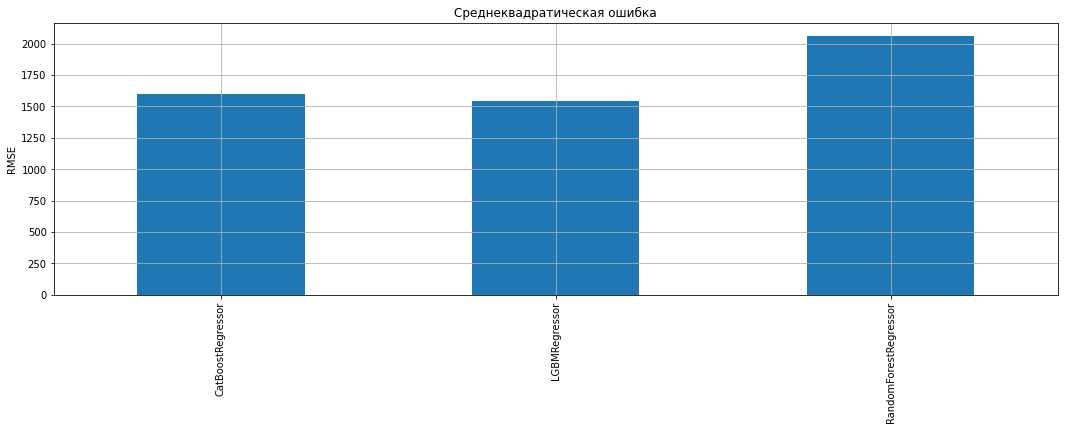

In [75]:
list_of_results.T['RMSE'].plot(kind='bar',
                               grid=True,
                               figsize=(18, 5),
                               ylabel='RMSE',
                               title='Среднеквадратическая ошибка');

Посмотрим на важность признаков

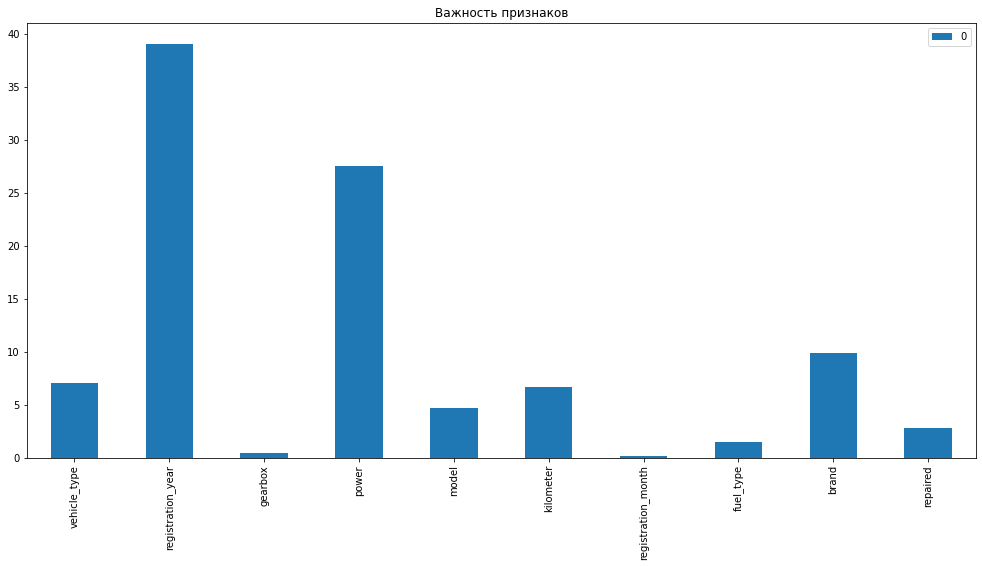

In [76]:
pd.DataFrame(cat_model.feature_importances_, x_train_cat.columns).plot(kind='bar', figsize=(17,8));
plt.title('Важность признаков');

## Вывод

- Был выполнен анализ и подготовка данных, в ходе которого были обработаны пропущенные значения, удалены данные с аномальными значениями.
- Было проведено сравнение моделей градиентного бустинга CatBoost, LightGBM и случайного леса.
- Были подобраны наилучшие параметры для моделей.
- Градиентный бустинг позволяет улучшить результат метрик по сравнению с более простыми алгоритмами.
- CatBoostRegressor - лучшая модель. CatBoostRegressor и LGBMRegressor схожи по RMSE, но CatBoostRegressor значительно превосходит по скорости обучения и предсказания.
- CatBoost и LGBM сравнимы по ошибке предсказания, но CatBoost значительно выигрывает в скорости обучения и предсказания.
- Самыми важными признаками являются год регистрации, мощность и бренд